# SCIALOG Statistical Analyses

Steps 1 - 3

In [49]:
import os
import seaborn as sns

# Climb up to the project root if currently inside a subdirectory
while os.path.basename(os.getcwd()) != "NICO_human-gemini":
    os.chdir("..")

print("Working directory:", os.getcwd())

Working directory: /Users/maxchalekson/Northwestern University/Summer 2025/NICO/NICO Research/NICO_human-gemini


In [50]:
# Set theme globally (do this once at the top of your notebook)
sns.set_theme(style="whitegrid", palette="colorblind")

## STEPS 1-2

### Max and Evey (code)

In [ ]:
import pandas as pd

def process_flat_sheet(filepath, coder_name):
    xls = pd.read_excel(filepath, sheet_name=None)
    all_dfs = []

    for sheet_name, df in xls.items():
        df.columns = [str(c).strip().lower() for c in df.columns]
        if not {'video', 'timestamp', 'speaker'}.issubset(df.columns):
            continue
        for i in range(4):  # Annotation columns are every other, starting from index 3
            annot_idx = 3 + i * 2
            if annot_idx >= len(df.columns):
                continue
            code_col = df.columns[annot_idx]
            temp = df[['video', 'timestamp', 'speaker', code_col]].copy()
            temp.columns = ['video', 'timestamp', 'speaker', 'annotation']
            temp['coder'] = coder_name
            temp['sheet'] = sheet_name
            all_dfs.append(temp.dropna(subset=['annotation']))
    return pd.concat(all_dfs, ignore_index=True)

# Load Max and Evey data
df_max = process_flat_sheet("Data/sampled video verification (Max).xlsx", "max")
df_evey = process_flat_sheet("Data/sampled video verification (Evey).xlsx", "evey")


### Gemini (code)

In [40]:
import json

def process_gemini_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    all_rows = []
    skipped_chunks = 0
    all_speakers = set()

    for video, chunks in data.items():
        for chunk_name, utterances in chunks.items():
            if not utterances or not isinstance(utterances, list):
                skipped_chunks += 1
                continue

            for utt in utterances:
                speaker = utt.get("speaker", "").strip()
                timestamp = utt.get("timestamp", "").strip()
                annotations = utt.get("annotations", [])
                video_name = chunk_name.split("/")[0]
                all_speakers.add(speaker)

                if isinstance(annotations, list):
                    for ann in annotations:
                        if isinstance(ann, dict):
                            for label, explanation in ann.items():
                                all_rows.append({
                                    "video": video_name,
                                    "timestamp": timestamp,
                                    "speaker": speaker,
                                    "annotation": label.strip(),
                                    "explanation": str(explanation).strip(),
                                    "coder": "gemini"
                                })
                elif isinstance(annotations, dict):
                    for label, explanation in annotations.items():
                        all_rows.append({
                            "video": video_name,
                            "timestamp": timestamp,
                            "speaker": speaker,
                            "annotation": label.strip(),
                            "explanation": str(explanation).strip(),
                            "coder": "gemini"
                        })

    df = pd.DataFrame(all_rows)
    print(f"\nGemini annotations loaded: {len(df)}")
    print(f"Unique speakers (Gemini): {len(all_speakers)}")
    print(f"Skipped malformed/empty chunks: {skipped_chunks}\n")
    print("Gemini annotation counts:")
    print(df['annotation'].value_counts())
    return df

df_gemini = process_gemini_json("Data/sampled_verification.json")



Gemini annotations loaded: 434
Unique speakers (Gemini): 141
Skipped malformed/empty chunks: 3

Gemini annotation counts:
annotation
expand on existing idea              99
explain or define term or concept    78
present new idea                     60
provide supporting evidence          52
propose decision                     30
ask clarifying question              29
acknowledge contribution             25
express enthusiasm                   15
express agreement                    14
encourage particpatioin              12
assign task                           5
reject idea                           3
offer constructive criticism          3
express frustation                    2
express alternative decision          2
confirm decision                      2
summarize key ideas                   1
express frustration                   1
express humor                         1
Name: count, dtype: int64


## Frequency Plot & Statistics (Max, Evey, Gemini)


Max annotation count statistics:
count    17.000000
mean     11.176471
std      11.822834
min       1.000000
25%       4.000000
50%       7.000000
75%      12.000000
90%      22.200000
max      49.000000
Name: count, dtype: float64


/var/folders/wp/cn7__9416yj3c5_vcykys8hc0000gn/T/ipykernel_53801/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


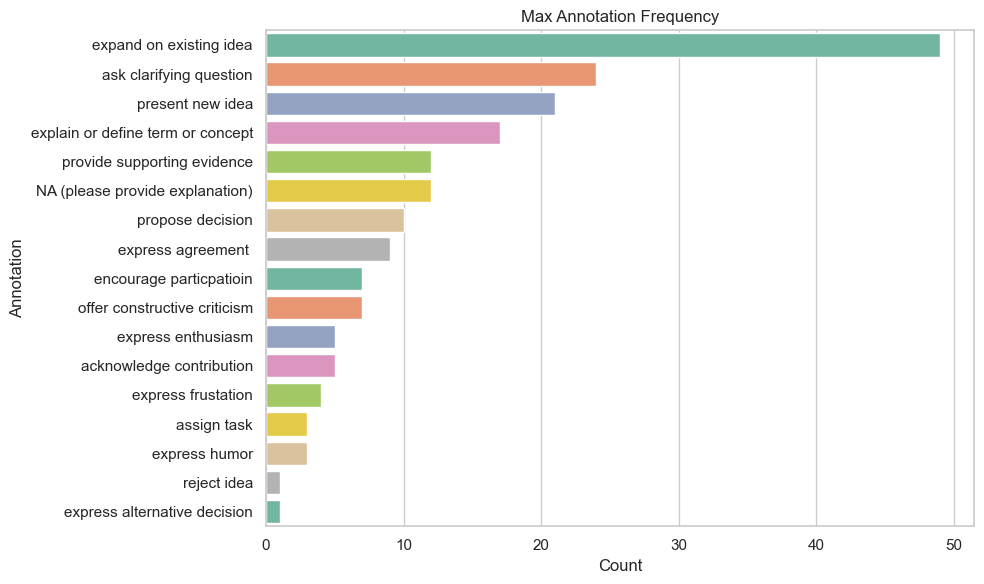


Evey annotation count statistics:
count    14.000000
mean     17.285714
std      14.018826
min       1.000000
25%      10.250000
50%      14.000000
75%      21.000000
90%      34.100000
max      51.000000
Name: count, dtype: float64


/var/folders/wp/cn7__9416yj3c5_vcykys8hc0000gn/T/ipykernel_53801/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


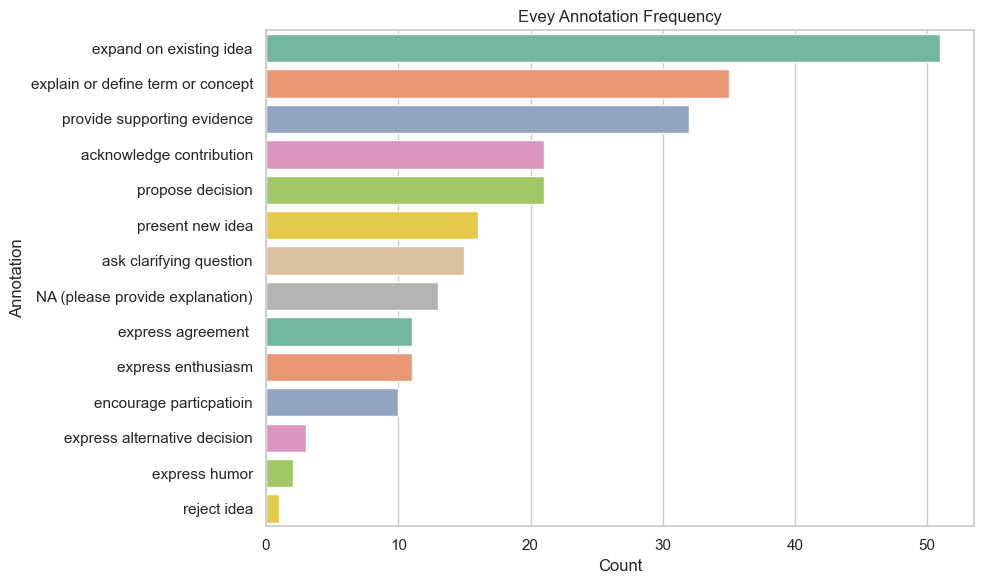

/var/folders/wp/cn7__9416yj3c5_vcykys8hc0000gn/T/ipykernel_53801/1228008109.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(



Gemini annotation count statistics:
count    19.000000
mean     22.842105
std      29.120942
min       1.000000
25%       2.000000
50%      12.000000
75%      29.500000
90%      63.600000
max      99.000000
Name: count, dtype: float64


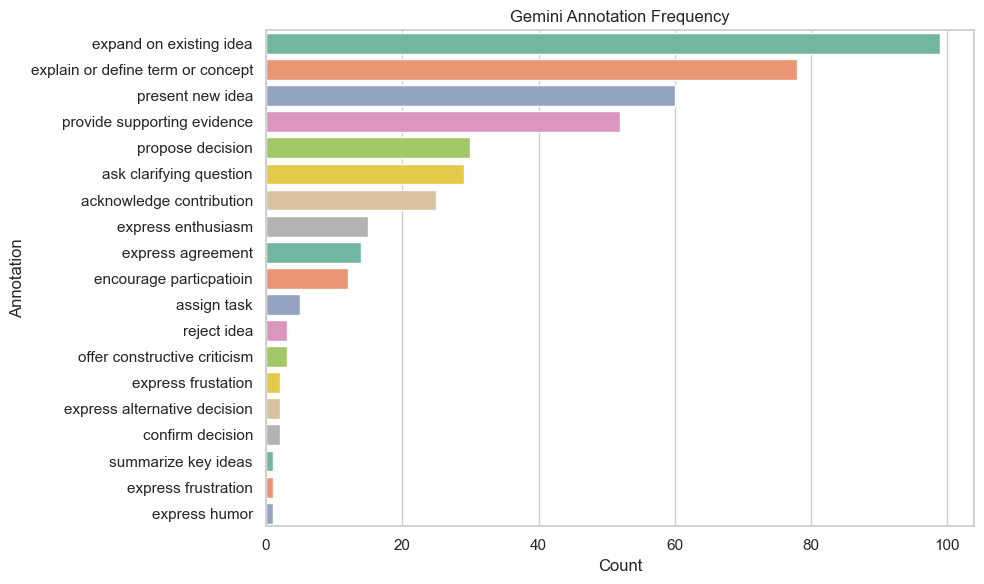

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_annotation_stats(df, coder_name):
    print(f"\n{coder_name} annotation count statistics:")
    print(df['annotation'].value_counts().describe(percentiles=[.25, .5, .75, .9]))

    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=df,
        y='annotation',
        order=df['annotation'].value_counts().index,
        palette='Set2'
    )
    plt.title(f"{coder_name} Annotation Frequency")
    plt.xlabel("Count")
    plt.ylabel("Annotation")
    plt.tight_layout()
    plt.show()

plot_annotation_stats(df_max, "Max")
plot_annotation_stats(df_evey, "Evey")
plot_annotation_stats(df_gemini, "Gemini")


## Co-Occurence Matrix and Heatmap (Max, Evey, Gemini)

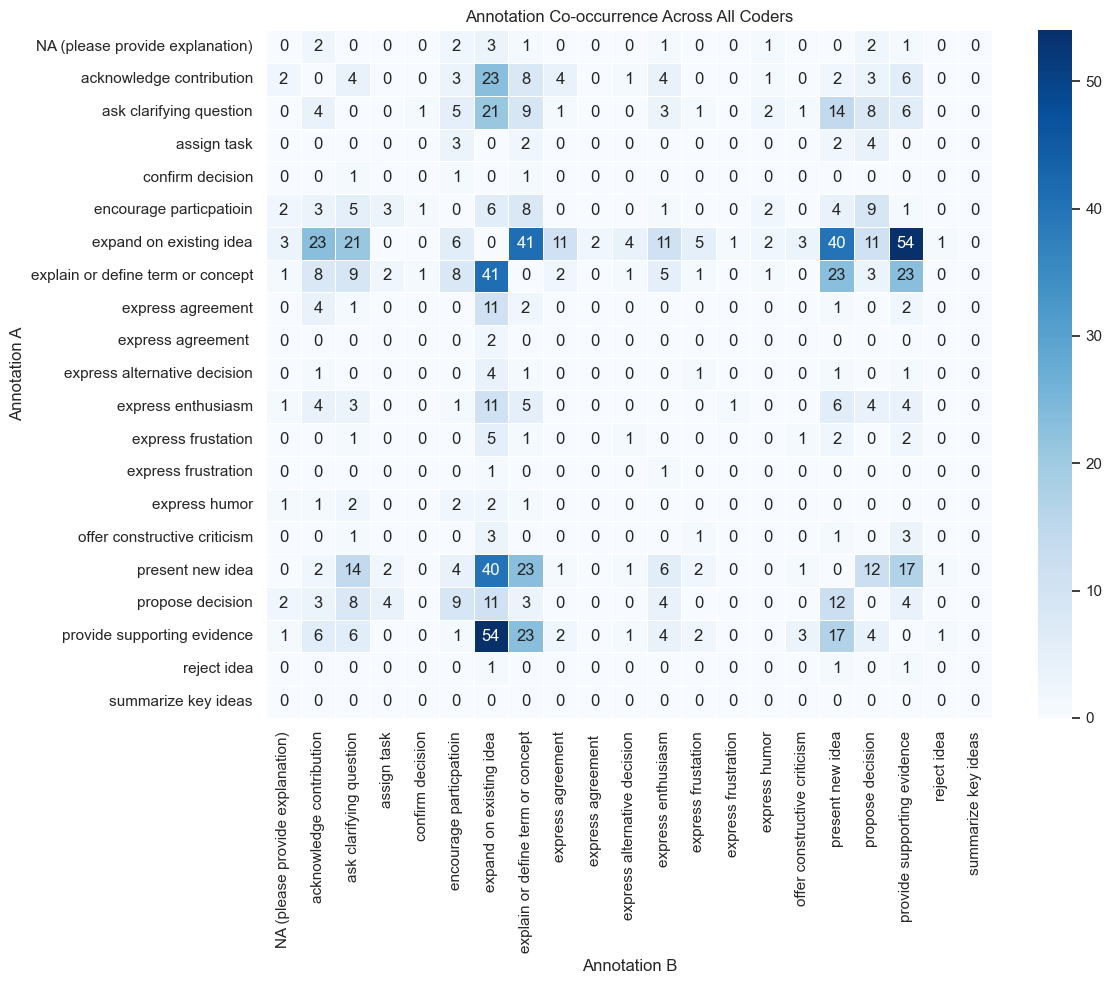

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combine all annotations
df_all = pd.concat([df_max, df_evey, df_gemini], ignore_index=True)

# Create a unique utterance ID
df_all['utterance_id'] = df_all['video'] + "_" + df_all['timestamp'] + "_" + df_all['speaker'].fillna("")

# Pivot to wide binary format
co_occurrence_df = pd.crosstab(df_all['utterance_id'], df_all['annotation'])

# Compute co-occurrence matrix
co_matrix = co_occurrence_df.T.dot(co_occurrence_df)

# Remove self-co-occurrence on the diagonal
for i in co_matrix.index:
    co_matrix.loc[i, i] = 0

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(co_matrix, cmap="Blues", annot=True, fmt="d", linewidths=0.5)

plt.title("Annotation Co-occurrence Across All Coders")
plt.xlabel("Annotation B")
plt.ylabel("Annotation A")
plt.tight_layout()
plt.show()



## Cohen's Kappa Calculation (Quadratically Weighted, Steps 2-3)

In [ ]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# 1. Clean Gemini fields
def clean_gemini_fields(df):
    df['video'] = df['video'].astype(str).str.replace('.mp4', '', regex=False).str.lower().str.strip()
    df['speaker'] = df['speaker'].astype(str).str.lower().str.strip()
    df['timestamp'] = df['timestamp'].astype(str).str.replace('[\[\]]', '', regex=True).str.strip()
    return df

# 2. Clean human coder 'video' fields to match Gemini format
def clean_video_filename(df):
    df['video'] = df['video'].astype(str)
    df['video'] = df['video'].str.extract(r'([^/\\]+)$')[0]  # take last part of path
    df['video'] = df['video'].str.replace(r'\.mp4.*$', '', regex=True)
    df['video'] = df['video'].str.replace(r'\?.*$', '', regex=True)
    df['video'] = df['video'].str.lower().str.strip()

    # 🔧 REMOVE _chunkX if present (to match Gemini)
    df['video'] = df['video'].str.replace(r'_chunk\d+', '', regex=True)

    return df



# 3. Create consistent utterance_id
def add_clean_utterance_id(df):
    return df.assign(
        utterance_id=(
            df['video'].astype(str).str.lower().str.strip() + "_" +
            df['timestamp'].astype(str).str.replace(r'[\[\]\s]', '', regex=True) + "_" +
            df['speaker'].astype(str).str.lower().str.strip()
        )
    )

# === Apply cleaning functions ===
df_max = clean_video_filename(df_max)
df_evey = clean_video_filename(df_evey)
df_gemini = clean_gemini_fields(df_gemini)

df_max = add_clean_utterance_id(df_max)
df_evey = add_clean_utterance_id(df_evey)
df_gemini = add_clean_utterance_id(df_gemini)

# 4. Compute Cohen’s Kappa by code
def compute_kappa_by_code(df1, df2, label1="coder1", label2="coder2", show_examples=True):
    merged = df1[['utterance_id', 'annotation']].merge(
        df2[['utterance_id', 'annotation']],
        on='utterance_id',
        suffixes=(f"_{label1}", f"_{label2}")
    )

    print(f"\nCohen's Kappa (quadratically weighted): {label1} vs {label2}")
    print(f"→ Overlapping utterances: {len(merged)}")

    if len(merged) == 0:
        print("\n No overlapping utterances found. Here's a sample of mismatched IDs:")
        unmatched = pd.merge(
            df1[['utterance_id']], df2[['utterance_id']],
            on='utterance_id', how='outer', indicator=True
        )
        print(unmatched[unmatched['_merge'] != 'both'].sample(5, random_state=1))
        return

    if show_examples:
        print("\nSample of merged annotations:")
        print(merged.head(5))

    codes = set(merged[f'annotation_{label1}']).union(set(merged[f'annotation_{label2}']))
    print("\nPer-code Cohen's Kappa:")
    for code in sorted(codes):
        bin1 = merged[f'annotation_{label1}'].apply(lambda x: 1 if x == code else 0)
        bin2 = merged[f'annotation_{label2}'].apply(lambda x: 1 if x == code else 0)
        score = cohen_kappa_score(bin1, bin2, weights="quadratic")
        print(f"{code:<35}: {score:.3f}")

# 5. Run comparisons
compute_kappa_by_code(df_max, df_evey, label1="max", label2="evey")
compute_kappa_by_code(df_max, df_gemini, label1="max", label2="gemini")
compute_kappa_by_code(df_evey, df_gemini, label1="evey", label2="gemini")

# 6. Optional: inspect samples
print("\nSample Gemini utterance_ids:")
print(df_gemini['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())

print("\nSample Max utterance_ids:")
print(df_max['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())

print("\nSample Evey utterance_ids:")
print(df_evey['utterance_id'].drop_duplicates().sample(5, random_state=42).to_list())



Cohen's Kappa (quadratically weighted): max vs evey
→ Overlapping utterances: 373

Sample of merged annotations:
                                        utterance_id  \
0  breakout_room_4_part_2_2021_04_22_13_14_53_00:...   
1                      nan_01:01-02:30_nandita garud   
2                         nan_03:00-03:34_mark mimee   
3  breakout_room_4_part_2_2021_04_22_13_14_53_07:...   
4  breakout_room_4_part_2_2021_04_22_13_14_53_07:...   

                      annotation_max                  annotation_evey  
0           acknowledge contribution         acknowledge contribution  
1                   present new idea  NA (please provide explanation)  
2            ask clarifying question          expand on existing idea  
3  explain or define term or concept          ask clarifying question  
4  explain or define term or concept                 present new idea  

Per-code Cohen's Kappa:
NA (please provide explanation)    : 0.207
acknowledge contribution           : 0.092
ask cl

## STEP 3

### Per-code Frequency Counts & Bar Plots

Max - Annotation Counts:
 annotation
expand on existing idea              49
ask clarifying question              24
present new idea                     21
explain or define term or concept    17
provide supporting evidence          12
NA (please provide explanation)      12
propose decision                     10
express agreement                     9
encourage particpatioin               7
offer constructive criticism          7
express enthusiasm                    5
acknowledge contribution              5
express frustation                    4
assign task                           3
express humor                         3
reject idea                           1
express alternative decision          1
Name: count, dtype: int64 

Evey - Annotation Counts:
 annotation
expand on existing idea              51
explain or define term or concept    35
provide supporting evidence          32
acknowledge contribution             21
propose decision                     21
present new idea 

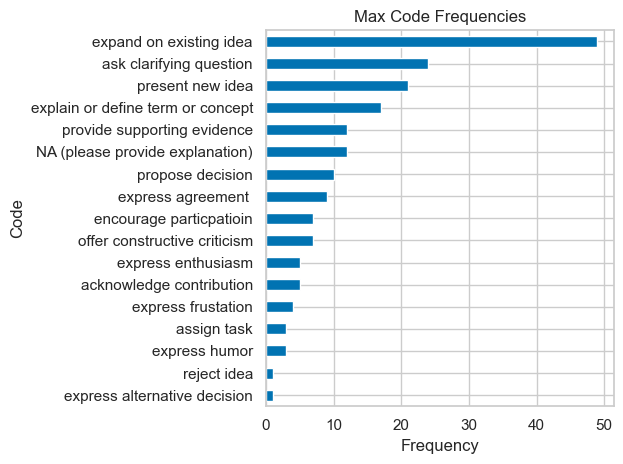

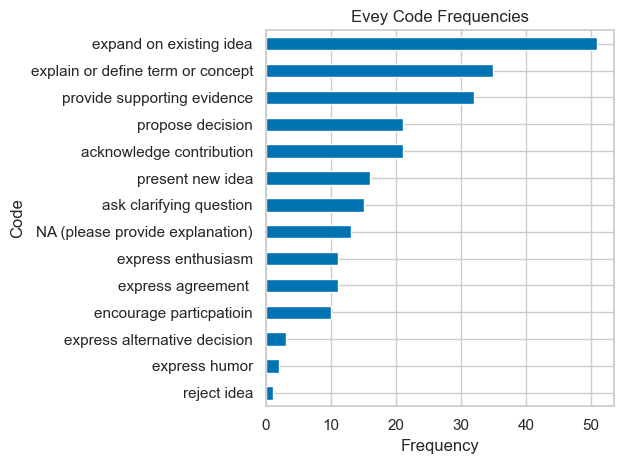

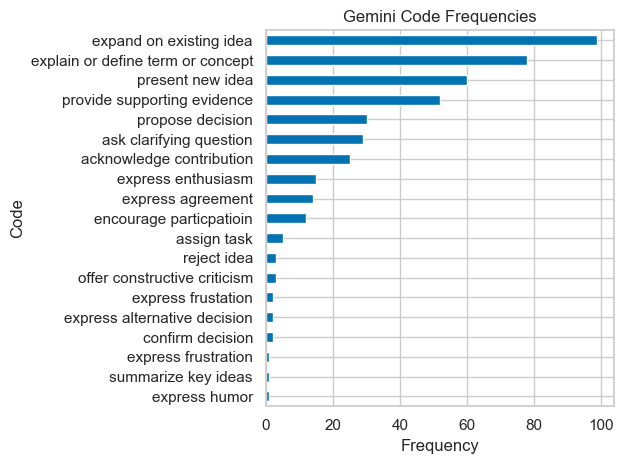

In [69]:
# 3a. Code frequency counts
print("Max - Annotation Counts:\n", df_max['annotation'].value_counts(), "\n")
print("Evey - Annotation Counts:\n", df_evey['annotation'].value_counts(), "\n")
print("Gemini - Annotation Counts:\n", df_gemini['annotation'].value_counts(), "\n")

# 3b. Bar plots for visual comparison
import matplotlib.pyplot as plt

for df, name in [(df_max, "Max"), (df_evey, "Evey"), (df_gemini, "Gemini")]:
    df['annotation'].value_counts().sort_values().plot(kind='barh', title=f"{name} Code Frequencies")
    plt.xlabel("Frequency")
    plt.ylabel("Code")
    plt.tight_layout()
    plt.show()


## Summary and Interpretation

Add in notes here

## Extra Notes

Add any extra notes here